In [30]:
from gp import *
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [31]:
import importlib
import gp
importlib.reload(gp)
from gp import *
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Dataset characteristics<br>
- instant: record index<br>
- dteday : date
- season : season (1:springer, 2:summer, 3:fall, 4:winter)
- yr : year (0: 2011, 1:2012)
- mnth : month (1 to 12)
- hr : hour (0 to 23)
- holiday : whether day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
+ weathersit : 
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp : Normalized temperature in Celsius. The values are divided to 41 (max)
- atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
- hum: Normalized humidity. The values are divided to 100 (max)
- windspeed: Normalized wind speed. The values are divided to 67 (max)
- casual: count of casual users
- registered: count of registered users
- cnt: count of total rental bikes including both casual and registered

In [32]:
import pandas as pd

df = pd.read_csv("hour.csv")
df

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119
17375,17376,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89
17376,17377,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90
17377,17378,2012-12-31,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61


# Data Preprocess

In [33]:
reference_date = pd.Timestamp('2011-01-01')
df.iloc[:, 1] = (pd.to_datetime(df.iloc[:, 1]) - reference_date).dt.days
data = df.to_numpy(dtype=float)
data

array([[1.0000e+00, 0.0000e+00, 1.0000e+00, ..., 3.0000e+00, 1.3000e+01,
        1.6000e+01],
       [2.0000e+00, 0.0000e+00, 1.0000e+00, ..., 8.0000e+00, 3.2000e+01,
        4.0000e+01],
       [3.0000e+00, 0.0000e+00, 1.0000e+00, ..., 5.0000e+00, 2.7000e+01,
        3.2000e+01],
       ...,
       [1.7377e+04, 7.3000e+02, 1.0000e+00, ..., 7.0000e+00, 8.3000e+01,
        9.0000e+01],
       [1.7378e+04, 7.3000e+02, 1.0000e+00, ..., 1.3000e+01, 4.8000e+01,
        6.1000e+01],
       [1.7379e+04, 7.3000e+02, 1.0000e+00, ..., 1.2000e+01, 3.7000e+01,
        4.9000e+01]])

In [34]:
X_whole = data[:, 1:14] # the first column is index, not necessary
Y_whole = data[:, 16] # count of total rental bikes as label
X_whole 

array([[0.000e+00, 1.000e+00, 0.000e+00, ..., 2.879e-01, 8.100e-01,
        0.000e+00],
       [0.000e+00, 1.000e+00, 0.000e+00, ..., 2.727e-01, 8.000e-01,
        0.000e+00],
       [0.000e+00, 1.000e+00, 0.000e+00, ..., 2.727e-01, 8.000e-01,
        0.000e+00],
       ...,
       [7.300e+02, 1.000e+00, 1.000e+00, ..., 2.576e-01, 6.000e-01,
        1.642e-01],
       [7.300e+02, 1.000e+00, 1.000e+00, ..., 2.727e-01, 5.600e-01,
        1.343e-01],
       [7.300e+02, 1.000e+00, 1.000e+00, ..., 2.727e-01, 6.500e-01,
        1.343e-01]])

In [35]:
def standardize(X):
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    return (X-mean)/std, mean, std

def split_train_test(X_whole, Y_whole, num=1500, rate=0.7):
    # Shuffle data first
    indices = jax.random.permutation(grab_prng(), X_whole.shape[0])
    X_part = X_whole[indices]
    Y_part = Y_whole[indices]
    
    indices = jax.random.permutation(grab_prng(), num)
    X_shuffled = X_part[indices]
    Y_shuffled = Y_part[indices]
    
    # Standardize the shuffled data
    X, mean, std = standardize(X_shuffled)
    Y, mean, std = standardize(Y_shuffled)

    # Use the same indices for Y
    # Y = Y_shuffled
    
    # Compute the split index
    split_idx = int(num * rate)
    
    # Split indices into train and test
    train_indices = indices[:split_idx]
    test_indices = indices[split_idx:]
    
    # Split data using the indices
    X_train = X[train_indices]
    Y_train = Y[train_indices]
    X_test = X[test_indices]
    Y_test = Y[test_indices]
    
    return X_train, Y_train, X_test, Y_test


In [36]:
def split_clml(X_train, Y_train, ratio=0.8):
    n_samples = X_train.shape[0]
    indices = jax.random.permutation(grab_prng(), n_samples)
     # Shuffle the data
    X_train_shuffled = X_train[indices]
    Y_train_shuffled = Y_train[indices]
    
    # Calculate the base size of each subset
    subset_size = int(n_samples * ratio)
    
    # Initialize lists to hold the subsets
    X_con = [X_train[:subset_size], X_train[subset_size:]]
    Y_con = [Y_train[:subset_size], Y_train[subset_size:]]
    
    return X_con, Y_con

def split_sequence(X_train, Y_train, seq_len=8):
    n_samples = X_train.shape[0]
    indices = jax.random.permutation(grab_prng(), n_samples)
     # Shuffle the data
    X_train_shuffled = X_train[indices]
    Y_train_shuffled = Y_train[indices]
    
    # Calculate the base size of each subset
    subset_size = n_samples // seq_len
    remainder = n_samples % seq_len
    
    # Initialize lists to hold the subsets
    X_seq = []
    Y_seq = []
    
    start_idx = 0
    for i in range(seq_len):
        # The first subset gets the remainder (extra) samples
        if i == 0:
            end_idx = start_idx + subset_size + remainder
        else:
            end_idx = start_idx + subset_size
        
        X_seq.append(X_train_shuffled[start_idx:end_idx])
        Y_seq.append(Y_train_shuffled[start_idx:end_idx])
        
        start_idx = end_idx
    return X_seq, Y_seq

In [56]:
X_train, Y_train, X_test, Y_test = split_train_test(X_whole, Y_whole, num=3000, rate=0.7)
X_con, Y_con = split_clml(X_train, Y_train, ratio=0.8)
X_seq, Y_seq = split_sequence(X_train, Y_train, seq_len=10)



# Hyperparameter initialization

Note that, in the below initialization, it is assumed that noise variance is the first component, signal variance the second, and length scale the third. Feel free to modify if using pytrees.

Further note: these are assumed constrained (strictly positive). You should map to unconstrained prior to running optimization, and map back to constrained when forming the GP posterior, and evaluating the predictive density for evaluation.

In [38]:
# def random_init_sqexp_hyperparams():
#     return np.array([jax.random.uniform(grab_prng(), minval=0.2, maxval=2),
#                      jax.random.uniform(grab_prng(), minval=0.2, maxval=2),
#                      X_train.shape[1]*jax.random.uniform(grab_prng(), minval=1, maxval=10)])
#

# Plotting code

In [39]:
def scatterplot(lml_lpd):
    plt.scatter(lml_lpd[:,0], lml_lpd[:,1])
    
    plt.xlabel('Log marginal likelihood')
    plt.ylabel('Negative log predictive density')
    plt.title('Is marginal likelihood a good indicator of generalization?')
    plt.legend()
#

# Experiment 1: Empirical Bayes for squared-exponential kernel

In [40]:
# n_trials = 20
# T = 200
# step_size = 5e-4

# gathered_trials = []
# hyperparams_inits = []
# for i in range(n_trials):
#    hyperparams_inits.append(random_init_sqexp_hyperparams())

# cov_func = sqexp_cov_function
# X_star = X_test
# for n in range(n_trials):
#    hyperparams_init = hyperparams_inits[n]
#    unconstrained_hyperparams_init = inverse_param_transform(hyperparams_init)
   
#    # sqexp_cov_function(X_train, X_train, unconstrained_hyperparams_init)
   
#    (unconstrained_hyperparams, lml) = empirical_bayes(cov_func, X_train, Y_train, unconstrained_hyperparams_init, step_size, T)
#    hyperparams = param_transform(unconstrained_hyperparams)
   
#    posterior_predictive = gp_posterior(cov_func, X_train, Y_train, hyperparams_init)
#    (posterior_mean, posterior_var) = posterior_predictive(X_star)
#    neg_log_initial = neg_log_predictive_density(Y_test, posterior_mean, posterior_var, hyperparams_init[0])

#    posterior_predictive = gp_posterior(cov_func, X_train, Y_train, hyperparams)
#    (posterior_mean, posterior_var) = posterior_predictive(X_star)
#    neg_log_final = neg_log_predictive_density(Y_test, posterior_mean, posterior_var, hyperparams[0])

#    print(np.array([neg_log_initial, neg_log_final, lml]))
#    gathered_trials.append(np.array([neg_log_initial, neg_log_final, lml]))
# #
# gathered_trials

In [41]:
# trials_array = np.array(gathered_trials)
# lml_lpd = np.column_stack((trials_array[:, 2], trials_array[:, 1]))
# scatterplot(lml_lpd)


# Dicsussion
1. Negative log probability was consistently improved over the hyperparameters used at initialization, across all runs.
2. According to the scatterplot above, we can see that as log marginal likelihood increases, negative log predicitive density on test set decreases at first, and increases later. Log marginal likelihood is a metric of our hyperparameters. The larger log marginal likelihood is, the better our hyperparameters are. But if they are better is determined by training set. Thus it's reasonable that "better" hyperparameters on training set don't always work better on test set. A large marginal likelihood may cause overfitting, although it works very well on training set. It's not a good indicator of generalization.

# Experiment 2 - feature importance using learned Mahalanobis distances

In [42]:
# use as your initial hyperparameters -> first two parameters are noise variance and signal variance,
# remaining parameters are length scale; feel free to modify if using pytrees
def random_init_sqexp_maha_hyperparams(X_train):
    var = jax.random.uniform(grab_prng(), shape=(2,), minval=0.2, maxval=2)
    length_scale = jax.random.uniform(grab_prng(), shape=(X_train.shape[1],), minval=1, maxval=10)
    return np.concatenate([var, length_scale])


In [43]:
# experiment settings
n_trials = 20

cov_func = sqexp_mahalanobis_cov_function
X_star = X_test
hyperparams_inits = []
for i in range(n_trials):
   hyperparams_inits.append(random_init_sqexp_maha_hyperparams(X_train))


In [46]:
import importlib
import gp
importlib.reload(gp)
from gp import *
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# optimize hyperparameters according lml
lml_trials = []
T = 200
step_size = 1e-4
for n in range(n_trials):
   hyperparams_init = hyperparams_inits[n]
   unconstrained_hyperparams_init = inverse_param_transform(hyperparams_init)
   (unconstrained_hyperparams, lml) = empirical_bayes(cov_func, X_train, Y_train, unconstrained_hyperparams_init, step_size, T)
   hyperparams = param_transform(unconstrained_hyperparams)
   
   posterior_predictive = gp_posterior(cov_func, X_train, Y_train, hyperparams_init)
   (posterior_mean, posterior_var) = posterior_predictive(X_star)
   neg_log_initial = neg_log_predictive_density(Y_test, posterior_mean, posterior_var, hyperparams_init[0])

   posterior_predictive = gp_posterior(cov_func, X_train, Y_train, hyperparams)
   (posterior_mean, posterior_var) = posterior_predictive(X_star)
   neg_log_final = neg_log_predictive_density(Y_test, posterior_mean, posterior_var, hyperparams[0])
   print(np.array([neg_log_initial, neg_log_final, lml]))
   lml_trials.append(np.array([neg_log_initial, neg_log_final, lml]))
# #

0 -735.5540995877795
1 -708.812888434064
2 -683.231615621253
3 -658.7882379192692
4 -635.4586351941724
5 -613.2166599452574
6 -592.0342140155569
7 -571.881351247584
8 -552.7264042720572
9 -534.5361330771182
10 -517.2758925273799
11 -500.9098156025239
12 -485.40100881710606
13 -470.7117560764562
14 -456.8037271231151
15 -443.6381867349385
16 -431.1762009460098
17 -419.37883676688637
18 -408.2073521698018
19 -397.62337346264087
20 -387.5890575864675
21 -378.0672373168675
22 -369.02154781224186
23 -360.4165334145966
24 -352.2177340552871
25 -344.3917510356491
26 -336.9062923300469
27 -329.73019788812985
28 -322.8334456893586
29 -316.18713952366494
30 -309.7634796385215
31 -303.5357175074682
32 -297.4780960442315
33 -291.5657766169241
34 -285.7747542183185
35 -280.0817621310324
36 -274.46416740363736
37 -268.8998584386669
38 -263.3671260023667
39 -257.8445390161303
40 -252.31081660095083
41 -246.74469804127057
42 -241.1248126386413
43 -235.42955186626955
44 -229.63694684250106
45 -223.7245

KeyboardInterrupt: 

C:\Users\Yue\AppData\Local\Temp\ipykernel_9632\1312685826.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


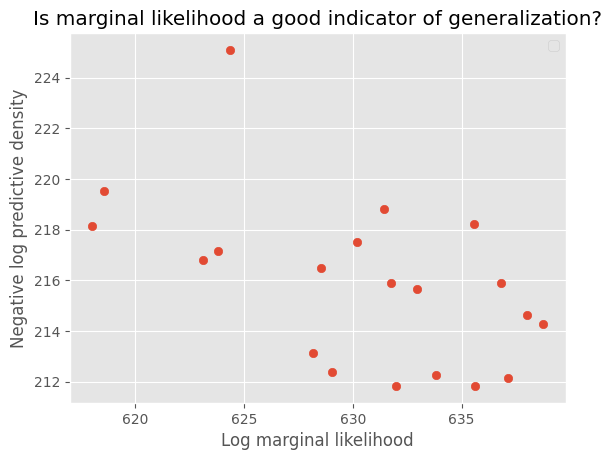

In [16]:
trials_array = np.array(lml_trials)
lml_lpd = np.column_stack((trials_array[:, 2], trials_array[:, 1]))
scatterplot(lml_lpd)

In [49]:
import importlib
import gp
importlib.reload(gp)
from gp import *
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# optimize hyperparameters according lml
clml_trials = []
T = 200
step_size = 1e-3
for n in range(n_trials):
   hyperparams_init = hyperparams_inits[n]
   unconstrained_hyperparams_init = inverse_param_transform(hyperparams_init)
   (unconstrained_hyperparams, clml) = clml_opt(cov_func, X_con, Y_con, unconstrained_hyperparams_init, step_size, T)
   hyperparams = param_transform(unconstrained_hyperparams)
   
   posterior_predictive = gp_posterior(cov_func, X_train, Y_train, hyperparams_init)
   (posterior_mean, posterior_var) = posterior_predictive(X_star)
   neg_log_initial = neg_log_predictive_density(Y_test, posterior_mean, posterior_var, hyperparams_init[0])

   posterior_predictive = gp_posterior(cov_func, X_train, Y_train, hyperparams)
   (posterior_mean, posterior_var) = posterior_predictive(X_star)
   neg_log_final = neg_log_predictive_density(Y_test, posterior_mean, posterior_var, hyperparams[0])
   print(np.array([neg_log_initial, neg_log_final, clml]))
   clml_trials.append(np.array([neg_log_initial, neg_log_final, clml]))

0 -512.8597927897557
1 -502.27923315268686
2 -492.87021053072993
3 -484.5461680362995
4 -477.21181447899124
5 -470.7656928053227
6 -465.10296033436794
7 -460.11813484161434
8 -455.7075700679961
9 -451.7714647750491
10 -448.21527100584524
11 -444.95043679174955
12 -441.89448407558666
13 -438.97047611452604
14 -436.105968221402
15 -433.23156648351437
16 -430.2792531468309
17 -427.18069335231917
18 -423.8658392996938
19 -420.2623156539495
20 -416.2963010385812
21 -411.895839578939
22 -406.9975036228136
23 -401.5566899788666
24 -395.56020770052777
25 -389.0375106008619
26 -382.0655307132991
27 -374.7636206022029
28 -367.2794114280234
29 -359.7700351143616
30 -352.3834401314008
31 -345.2428256839754
32 -338.4360305051825
33 -332.0110635870949
34 -325.9777907087266
35 -320.3141841867283
36 -314.97443416965575
37 -309.8962290179659
38 -305.00544864710156
39 -300.2176590937041
40 -295.4365839510091
41 -290.5501217153183
42 -285.4248640749448
43 -279.90105097397236
44 -273.7921459536861
45 -266

KeyboardInterrupt: 

C:\Users\Yue\AppData\Local\Temp\ipykernel_9632\1312685826.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


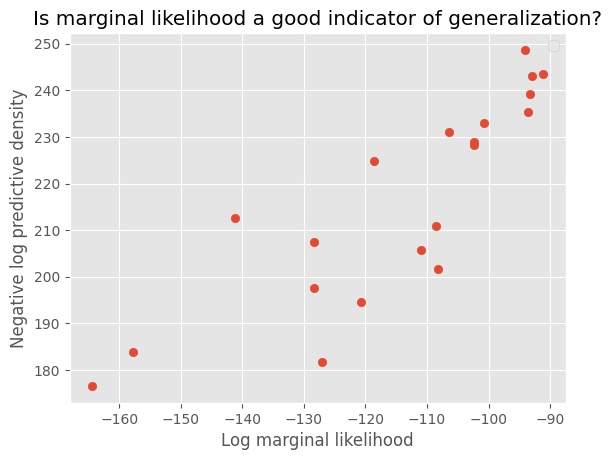

In [18]:
trials_array = np.array(clml_trials)
clml_lpd = np.column_stack((trials_array[:, 2], trials_array[:, 1]))
scatterplot(clml_lpd)

In [50]:
import importlib
import gp
importlib.reload(gp)
from gp import *
import matplotlib.pyplot as plt
plt.style.use('ggplot')

clml_function = conditional_log_marginal_likelihood(cov_func, X_con, Y_con)
aaa=clml_function(unconstrained_hyperparams)

clmls_function = conditional_log_marginal_likelihood_sequence(cov_func, X_seq, Y_seq)
clml_vals=clmls_function(unconstrained_hyperparams)


In [51]:
# clml_vals=np.array([-135.9522107,  -133.7928272 , -132.70732402, -128.74401939, -121.31757044, -120.19724961, -114.741562  ])
clml_vals

Array([-170.91510286,  -85.11387926,  -74.56947646,  -85.57616792,
        -62.00815416,  -42.50892247,  -28.60549176], dtype=float64)

-134.68889239541915 18.739288184959186


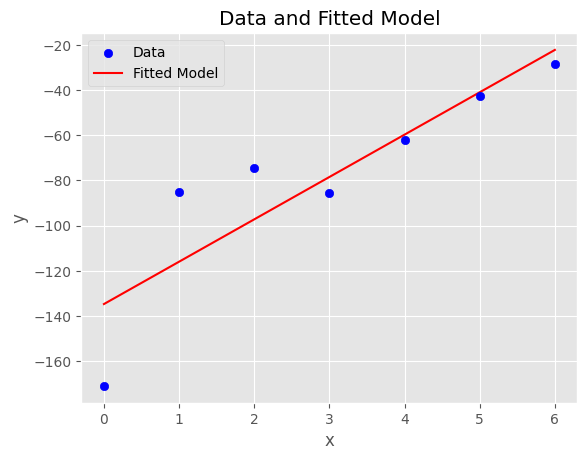

In [52]:
import importlib
import gp
importlib.reload(gp)
from gp import *
import matplotlib.pyplot as plt
plt.style.use('ggplot')

a,b =opt_clmls(clml_vals)
print(a,b)
x_data = np.arange(len(clml_vals))
y_data = np.array(clml_vals)
x_fit = np.linspace(min(x_data), max(x_data), 100)  # Smooth x range for the fitted curve
y_fit = a + b * x_fit

# Plot the data
plt.scatter(x_data, y_data, color='blue', label='Data', zorder=5)

# Plot the fitted model
plt.plot(x_fit, y_fit, color='red', label='Fitted Model', zorder=4)

# Add labels, legend, and title
plt.xlabel('x')
plt.ylabel('y')
plt.title('Data and Fitted Model')
plt.legend()


In [55]:

import importlib
import gp
importlib.reload(gp)
from gp import *
import matplotlib.pyplot as plt
plt.style.use('ggplot')



# optimize hyperparameters according lml
clmls_trials = []
T=200
step_size = 5e-3
for n in range(n_trials):
   hyperparams_init = hyperparams_inits[n]
   unconstrained_hyperparams_init = inverse_param_transform(hyperparams_init)
   (unconstrained_hyperparams, clmls) = clmls_opt(cov_func, X_seq, Y_seq, unconstrained_hyperparams_init, step_size, T)
   hyperparams = param_transform(unconstrained_hyperparams)
   
   posterior_predictive = gp_posterior(cov_func, X_train, Y_train, hyperparams_init)
   (posterior_mean, posterior_var) = posterior_predictive(X_star)
   neg_log_initial = neg_log_predictive_density(Y_test, posterior_mean, posterior_var, hyperparams_init[0])

   posterior_predictive = gp_posterior(cov_func, X_train, Y_train, hyperparams)
   (posterior_mean, posterior_var) = posterior_predictive(X_star)
   neg_log_final = neg_log_predictive_density(Y_test, posterior_mean, posterior_var, hyperparams[0])
   print(np.array([neg_log_initial, neg_log_final, clmls]))
   clmls_trials.append(np.array([neg_log_initial, neg_log_final, clmls]))

0 -308.1013768450747
1 -288.1876576325701
2 -276.13496590516746
3 -268.65985368850255
4 -262.87541507972605
5 -256.68432586955674
6 -248.28162265626418
7 -235.71322542987733
8 -218.25589004398745
9 -199.05758222411987
10 -182.280476787243
11 -168.9230492344141
12 -157.3189429115688
13 -144.55937523361865
14 -125.49815659064069
15 -95.91881972589522
16 -71.02135631918739
17 -55.482923387535294
18 -43.93994594407954
19 -34.916577269648116
20 -27.504722613361935
21 -21.26146703292443
22 -15.985614497059373
23 -11.463342825162044
24 -7.4626299074831195
25 -3.807660739581422
26 -0.39393604721271913
27 2.831081129020788
28 5.889550893235054
29 8.788555111368822
30 11.529673659488168
31 14.11466946152467
32 16.548489935016903
33 18.84024073617269
34 21.002647057583545
35 23.050601225142657
36 24.999445059740765
37 26.863522750101424
38 28.655297978093813
39 30.385072305065364
40 32.06116607741501
41 33.69035753827205
42 35.2783947515469
43 36.83045347102677
44 38.35147571363393
45 39.84636987

KeyboardInterrupt: 

In [ ]:
trials_array = np.array(clmls_trials)
clmls_lpd = np.column_stack((trials_array[:, 2], trials_array[:, 1]))
scatterplot(clmls_lpd)

In [149]:
clml_function = conditional_log_marginal_likelihood_sequence(cov_func, X_seq, Y_seq)
clml_vals=clml_function(hyperparams)

[-139.76797179    3.7072365     0.36232671    0.26977747]


In [111]:
clml_vals

[Array(-144.88906846, dtype=float64),
 Array(-142.56430816, dtype=float64),
 Array(-142.10506235, dtype=float64),
 Array(-141.66981794, dtype=float64),
 Array(-141.33357905, dtype=float64),
 Array(-140.54167117, dtype=float64),
 Array(-139.98196877, dtype=float64)]

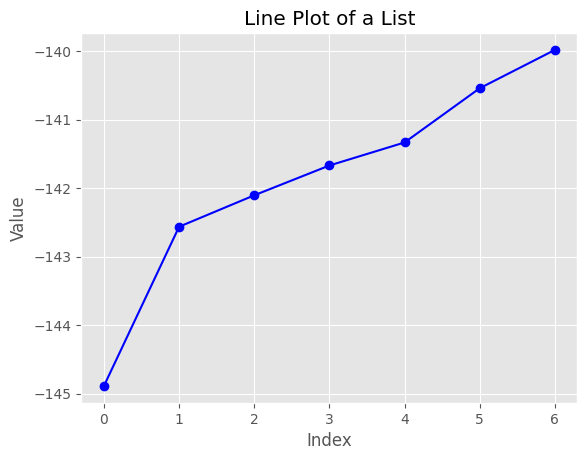

In [70]:
plt.plot(seq, marker='o', linestyle='-', color='b')

# Add labels and title
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Line Plot of a List')

# Show the plot
plt.show()